# Preparação do Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/var/folders/05/8sd3s_9j5yx83mfwsr37_l9w0000gq/T/ipykernel_3236/2192345894.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [2]:
try:
    from google.colab import drive
    diretorio = 'drive/My Drive/dataScience/'
    drive.mount('/content/drive')
except:
    diretorio = ''

In [3]:
from sklearn.utils import shuffle

df = pd.read_csv(diretorio + 'dataset.csv')
df.columns = [i.lower().strip().replace(' ', '_') for i in df.columns]
mantem = [
    'bwd_packet_length_mean', 'bwd_packet_length_std',
    'bwd_packet_length_min', 'fwd_packet_length_mean',
    'fwd_packet_length_std', 'fwd_packet_length_min', 'bwd_iat_max',
    'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_total', 'fwd_psh_flags',
    'bwd_header_length', 'bwd_init_win_bytes', 'fwd_init_win_bytes',
    'fwd_act_data_pkts', 'idle_mean', 'packet_length_mean',
    'packet_length_max', 'subflow_fwd_packets', 'total_fwd_packet',
    'protocol', 'fin_flag_count', 'syn_flag_count', 'psh_flag_count',
    'label'
]
df['label'] = df['label'].map({'Non-Tor': 0, 'Tor': 1, 'NonVPN': 2, 'VPN': 3})

df = shuffle(df[mantem], random_state=21).reset_index(drop=True)

## Separar o dataset em 2 porções

In [4]:
int_80 = int(df.shape[0] * 0.8)

df_80 = df.loc[:int_80, :]
df_20 = df.loc[int_80:, :]

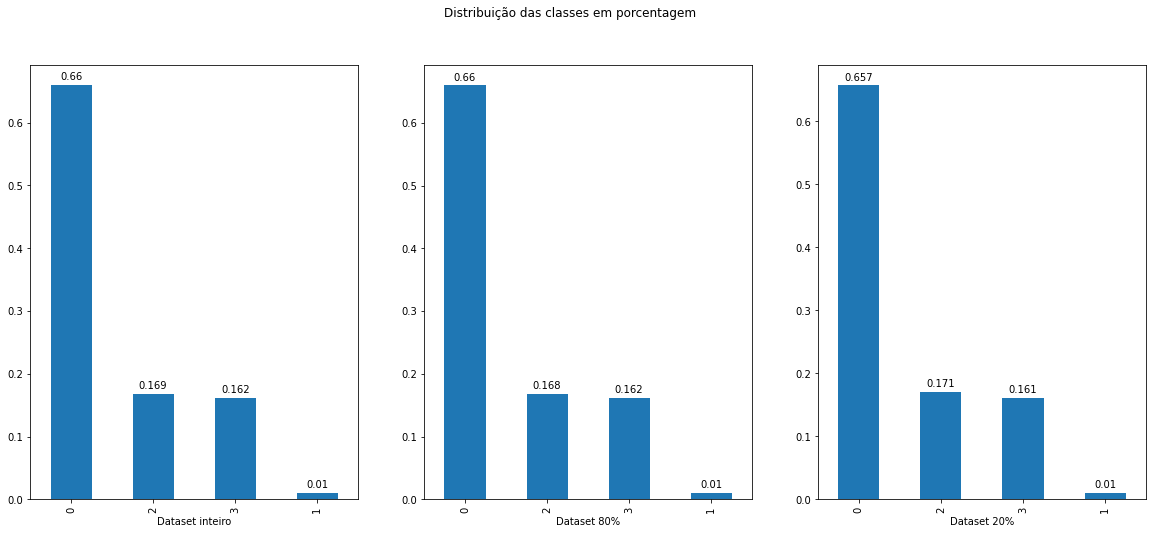

In [5]:
def adiciona_anotacao(axis):
    for rect in axis.patches:
        height = round(rect.get_height(), 3)
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig, axs = plt.subplots(1, 3, figsize=(20,8))
ax = df['label'].value_counts(normalize=True).plot.bar(ax=axs[0])
adiciona_anotacao(ax)
ax.set_xlabel('Dataset inteiro')

ax1 = df_80['label'].value_counts(normalize=True).plot.bar(ax=axs[1])
adiciona_anotacao(ax1)
ax1.set_xlabel('Dataset 80%')

ax2 =df_20['label'].value_counts(normalize=True).plot.bar(ax=axs[2])
adiciona_anotacao(ax2)
ax2.set_xlabel('Dataset 20%')

plt.suptitle('Distribuição das classes em porcentagem')
plt.show()

# Treinamento

In [6]:
X = df_80[mantem[:-1]]
y = df_80['label']

In [7]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split

from datetime import datetime

kf5 = KFold(n_splits=5)

In [8]:
try:
    import scikitplot as skplt
except:
    !pip install scikit-plot
    import scikitplot as skplt

In [9]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [10]:

import time

## Funções Auxiliares

### Paralelismo

As primeira execuções mostraram que a predição pode ser demorada.
Suponho que seja por conta de ser uma classifição multiclasse e não binária.

Assim, para tentar melhorar um pouco o tempo de espera, as execuções são paralelas.
Para isso foi usado o `ipyparallel`.

In [11]:
def predict_wrapper(x):
    clf, X_test, isProba = x
    if isProba:
        return clf.predict_proba(X_test)
    else:
        return clf.predict(X_test)

def get_predict_params(clf, X_test, cluster=None, targets=None, debug=True):
    import ipyparallel as ipp
    import logging
    
    start_time = datetime.now()
    args = [ (clf, X_test, False), (clf, X_test, True) ]
    
    newCluster = cluster
    if newCluster is None:
        log_level = int(logging.ERROR)
        newCluster = ipp.Cluster(log_level=log_level, n=2)
    
    client = newCluster.connect_client_sync()
    
    view = client.load_balanced_view(targets=targets)
    asyncresult = view.map_async(predict_wrapper, args)
    
    if debug:
        while not asyncresult.done():
            print('[ Executando ]', end=' ')
            print(datetime.now() - start_time, end='\r')
            time.sleep(1)

        print()
    
    client.close()
    if cluster is None:
        newCluster.stop_cluster_sync()
    
    l = asyncresult.get()
        
    return l

In [12]:
def predict(clf, X_test, y_test, cluster=None, targets=None):
    start_time = datetime.now()
    y_pred, y_proba = get_predict_params(clf, X_test, cluster, targets)
    predict_time = datetime.now() - start_time

    print('Tempo de predição:', predict_time)
    print()
    
    precisao = metrics.precision_score(y_test, y_pred, average='weighted')
    print('Precisão:', precisao)
    
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    print('Recall:', recall)
    
    f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
    print('F1 Score:', f1_score)
    
    erro = (y_test != y_pred).sum() / len(y_test)
    print('Erro:', erro)
    
    fig, axs = plt.subplots(1, 2, figsize=(20,6))
    skplt.metrics.plot_roc(y_test, y_proba,
                                 plot_micro=False, plot_macro=False,
                                 ax=axs[0])
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, ax=axs[1])
    
    plt.show()

    return [precisao, erro, recall, f1_score]

In [13]:
def train_predict_percentage(cluster, ClassifierModel, **classifier_kwargs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=21)
    
    clf = make_pipeline(MinMaxScaler(feature_range=(0,1)),
                        OneVsRestClassifier(ClassifierModel(**classifier_kwargs)))

    start_time = datetime.now()
    clf.fit(X_train, y_train)
    train_time = datetime.now() - start_time
    
    print('Tempo de treino:', train_time)
    predict(clf, X_test, y_test, cluster=cluster, targets=[0,1])

    return clf

In [14]:
def wrapper_4(x):    
    from sklearn import metrics
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.multiclass import OneVsRestClassifier    
    
    idx, train_index, test_index, X, y, ClassifierModel, classifier_kwargs = x
    
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    clf = make_pipeline(MinMaxScaler(feature_range=(0,1)),
                        OneVsRestClassifier(ClassifierModel(**classifier_kwargs)))

    from datetime import datetime
    
    start_time = datetime.now()
    clf.fit(X_train, y_train)
    train_time = datetime.now() - start_time

    start_time = datetime.now()
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    predict_time = datetime.now() - start_time
    
    try:
        roc_score = metrics.roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr')
    except:
        roc_score = 'Deu ruim para '+ str(idx)

    return (
        roc_score,
        idx,
        y_test,
        y_pred,
        y_proba,
        train_time,
        predict_time,
    )


def parallel_train_predict_kfold_2(cluster, ClassifierModel, **classifier_kwargs):    
    start_time = datetime.now()
    
    args = [ (idx, train_index, test_index, X, y, ClassifierModel, classifier_kwargs)
                for idx, (train_index, test_index) in enumerate(kf5.split(X)) ]

    with cluster.connect_client_sync() as client:
        view = client.load_balanced_view()
        #view.push({ 'get_predict_params': lambda clf, X_text: get_predict_params()})
        asyncresult = view.map_async(wrapper_4, args)
        while not asyncresult.done():
            print('Tempo de Execução:', end=' ')
            print(datetime.now() - start_time, end='\r')
            time.sleep(1)
            
        print()
        l = asyncresult.get()

    results = l
    fig, axs = plt.subplots(1, 2, figsize=(20,6))
    
    _, idx, y_test, y_pred, y_proba, train_t, predict_t = sorted(results,
                                                        reverse=True)[0]
    
    skplt.metrics.plot_roc(y_test, y_proba,
                                 plot_micro=False, plot_macro=False,
                                 ax=axs[0])
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, ax=axs[1])

    print('\nMelhor fold:', idx + 1)
    print('Tempo de treino:', train_t)
    print('Tempo de predição:', predict_t)
    print()
    print('Precisão:', metrics.precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', metrics.recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score:', metrics.f1_score(y_test, y_pred, average='weighted'))
    print('Erro:', (y_test != y_pred).sum() / len(y_test))
    
    plt.show()

#### Criação do cluster

In [15]:
def configure_cluster(n=5):
    import ipyparallel as ipp
    import logging
    
    log_level = int(logging.WARN)
    
    cluster = ipp.Cluster(log_level=log_level, n=n)
    cluster.start_cluster_sync()
    
    return cluster

In [16]:
cluster = configure_cluster(5*3)

## KNN

Mudar os parâmetros de vizinhos e peso deu uma leve melhorada no modelo. Foi tentado outras alterações, mas não houve melhora no resultado.

|Parâmetro|Padrão|Valor Especificado|
|---|---|---|
|`n_neighbors`|5|4|
|`weights`|uniform|distance|

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
knn_params = { 'n_neighbors': 4, 'weights': 'distance' }

Tempo de treino: 0:00:00.086591
[ Executando ] 0:03:22.791750
Tempo de predição: 0:03:23.800536

Precisão: 0.9423643057190809
Recall: 0.9418856259659969
F1 Score: 0.9415865449874726
Erro: 0.05811437403400309


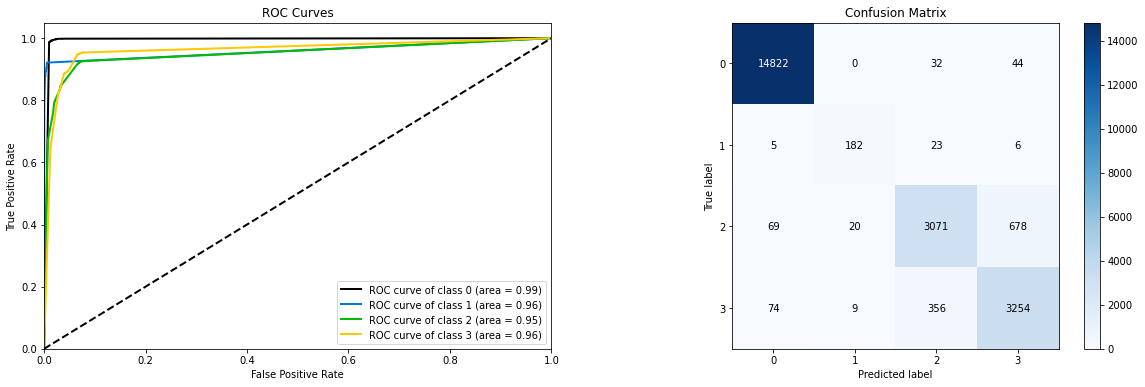

In [21]:
knn_0 = train_predict_percentage(cluster, KNeighborsClassifier, **knn_params)

Tempo de Execução: 0:11:34.582086

Melhor fold: 3
Tempo de treino: 0:00:00.133109
Tempo de predição: 0:11:31.084645

Precisão: 0.9437220459458449
Recall: 0.9412673879443586
F1 Score: 0.9408867862259968
Erro: 0.05873261205564142


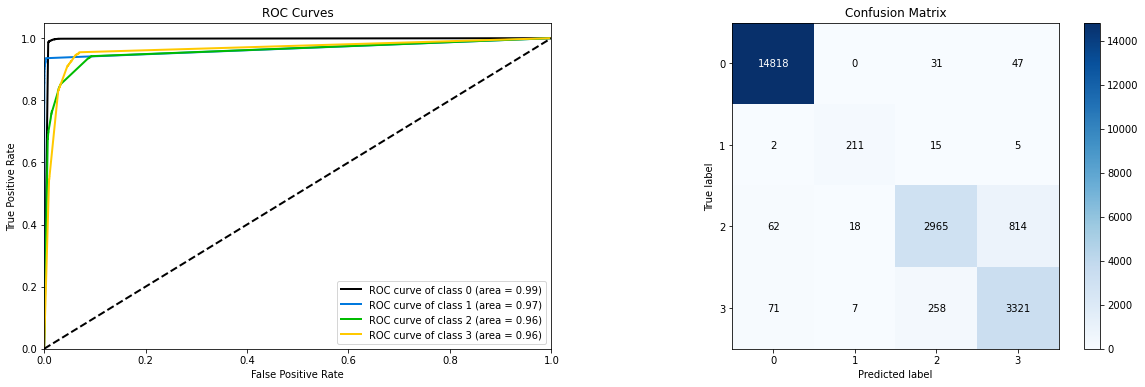

In [22]:
parallel_train_predict_kfold_2(cluster, KNeighborsClassifier, **knn_params)

## Random Forest

Nesse modelo eu só reduzi a quantidade de árvores na floresta e coloquei um número para deixar o randômico reproduzível.

|Parâmetro|Padrão|Valor Especificado|
|---|---|---|
|`n_estimators`|100|75|
|`random_state`|`None`|21|

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf_params = { 'n_estimators': 75, 'random_state': 21 }

Tempo de treino: 0:00:26.073095
[ Executando ] 0:00:01.142377
Tempo de predição: 0:00:02.147195

Precisão: 0.9583194312369185
Recall: 0.9582247736807242
F1 Score: 0.9581209043806488
Erro: 0.04177522631927578


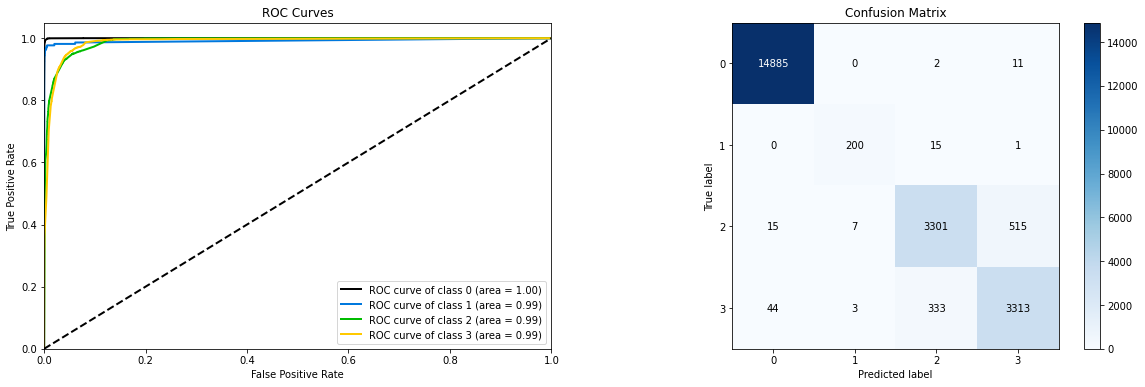

In [25]:
rf_0 = train_predict_percentage(cluster, RandomForestClassifier, **rf_params)

Tempo de Execução: 0:00:36.268241

Melhor fold: 4
Tempo de treino: 0:00:33.031581
Tempo de predição: 0:00:01.474598

Precisão: 0.9585755871366498
Recall: 0.9587105321262972
F1 Score: 0.9585610245276202
Erro: 0.0412894678737028


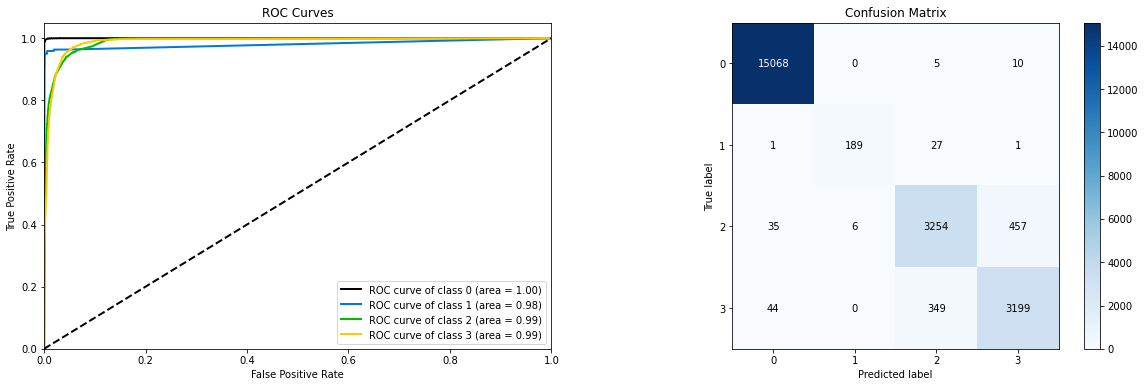

In [26]:
parallel_train_predict_kfold_2(cluster, RandomForestClassifier, **rf_params)

## Support Vector Machine

Devido a proporção de classes estar desbalanceada, foi preciso ajustar o class_weight. O probability é devido ao dataset ser multiclass. Já o max_iter foi definido para possibilitar a execução, pois numa primeira tentativa a execução passou de 1h e não terminou.

|Parâmetro|Padrão|Valor Especificado|
|---|---|---|
|`class_weight`|`None`|balanced|
|`random_state`|`None`|21|
|`cache_size`|200|500|
|`probability`|`False`|`True`|
|`max_iter`|-1|1000|

O problema de definir o max_iter, é que isso impactou drasticamente nas predições.


In [27]:
from sklearn.svm import SVC

In [28]:
svm_params = {
    'class_weight': 'balanced', 'random_state': 21,
    'cache_size': 500, 'probability': True, 'max_iter': 1000
}

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Tempo de treino: 0:04:54.498331
[ Executando ] 0:00:10.050498
Tempo de predição: 0:00:11.054560

Precisão: 0.051532495207461976
Recall: 0.16732170457054538
F1 Score: 0.07765478667124145
Erro: 0.8326782954294546


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


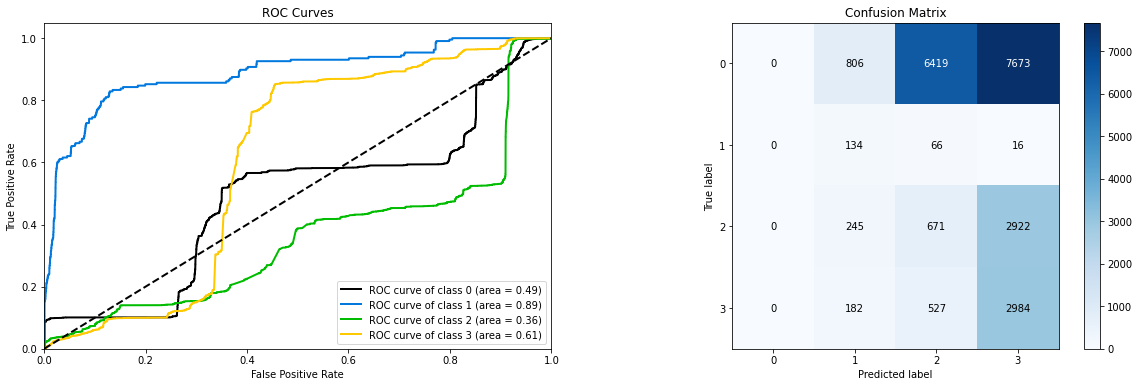

In [29]:
svm_0 = train_predict_percentage(cluster, SVC, **svm_params)

Tempo de Execução: 0:06:01.166526

Melhor fold: 5
Tempo de treino: 0:05:40.372615
Tempo de predição: 0:00:20.676251

Precisão: 0.6260247204927564
Recall: 0.22380216383307575
F1 Score: 0.17886525792816566
Erro: 0.7761978361669243


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


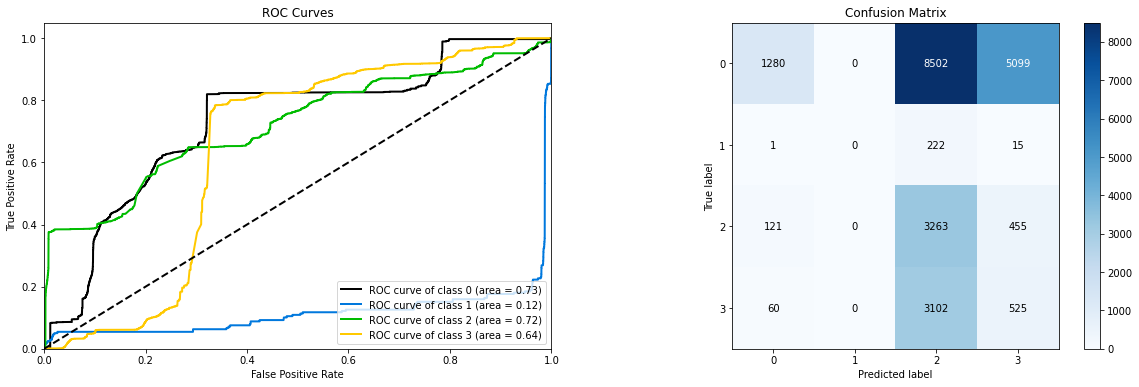

In [30]:
parallel_train_predict_kfold_2(cluster, SVC, **svm_params)

In [31]:
def train_with_80(ClassifierModel, **classifier_kwargs):    
    clf = make_pipeline(MinMaxScaler(feature_range=(0,1)),
                        OneVsRestClassifier(ClassifierModel(**classifier_kwargs)))

    start_time = datetime.now()
    clf.fit(X, y)
    train_time = datetime.now() - start_time
    
    print('Tempo de treino:', train_time)

    return clf

In [32]:
knn = train_with_80(KNeighborsClassifier, **knn_params)

Tempo de treino: 0:00:00.090339


In [33]:
rf = train_with_80(RandomForestClassifier, **rf_params)

Tempo de treino: 0:00:21.533629


In [34]:
svm = train_with_80(SVC, **svm_params)

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Tempo de treino: 0:05:22.412367


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


# Teste
Usando os 20% como dados de produção

In [35]:
X_test = df_20[mantem[:-1]]
y_test = df_20['label']

[ Executando ] 0:04:22.433369
Tempo de predição: 0:04:23.438444

Precisão: 0.9459066574415735
Recall: 0.9455945735886384
F1 Score: 0.9452923312344917
Erro: 0.05440542641136155


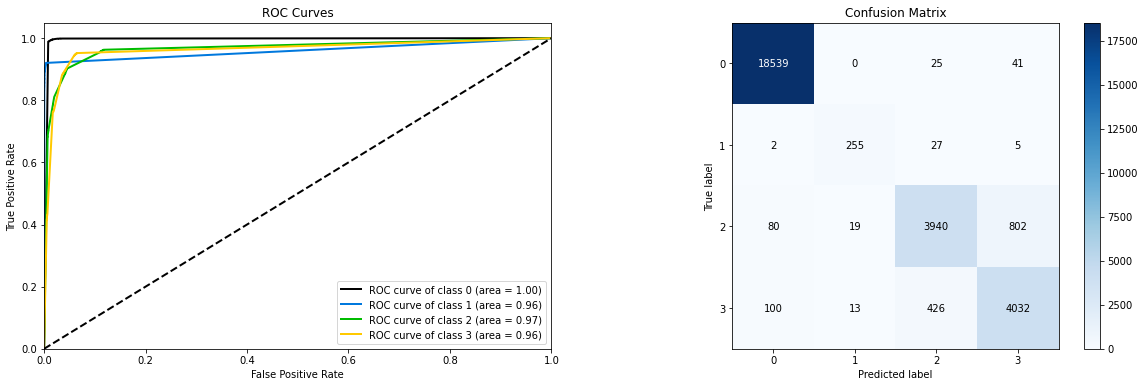

In [36]:
knn_result = predict(knn, X_test, y_test, cluster, [0,1])

[ Executando ] 0:00:00.202328
Tempo de predição: 0:00:01.204750

Precisão: 0.9595788531109224
Recall: 0.9596198685790999
F1 Score: 0.9595050207319147
Erro: 0.04038013142090016


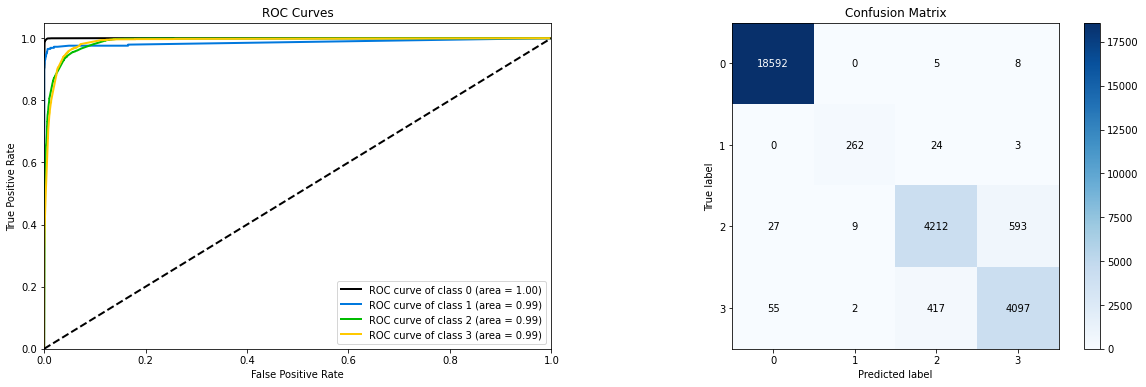

In [37]:
rf_result = predict(rf, X_test, y_test, cluster, [0,1])

[ Executando ] 0:00:11.062507
Tempo de predição: 0:00:12.072883

Precisão: 0.062157639823627354
Recall: 0.0585741538896347
F1 Score: 0.026269886578276884
Erro: 0.9414258461103653


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


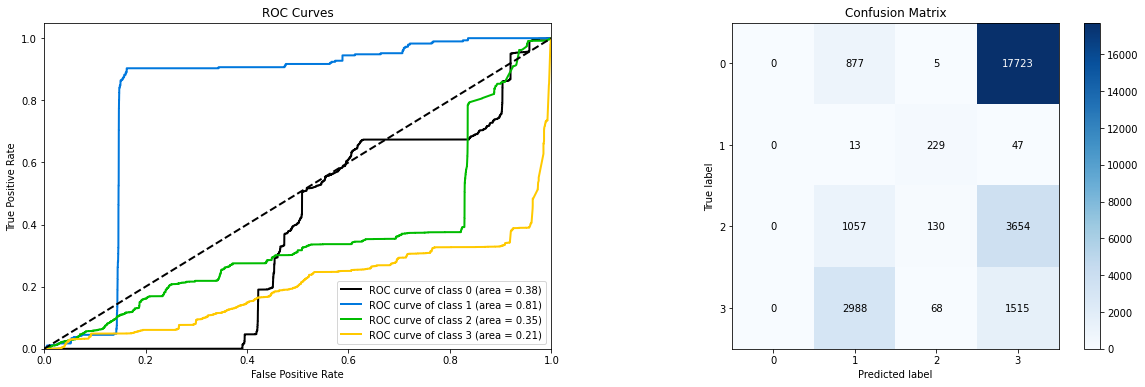

In [38]:
svm_result = predict(svm, X_test, y_test, cluster, [0,1])

In [39]:
resultado = pd.DataFrame.from_dict({
    'KNN': knn_result,
    'Random Forest': rf_result,
    'SVM': svm_result
}, orient='index')
resultado.columns = ['Precisão', 'Erro', 'Recall', 'F1 Score']

In [40]:
resultado

,Precisão,Erro,Recall,F1 Score
KNN,0.945907,0.054405,0.945595,0.945292
Random Forest,0.959579,0.040380,0.959620,0.959505
SVM,0.062158,0.941426,0.058574,0.026270


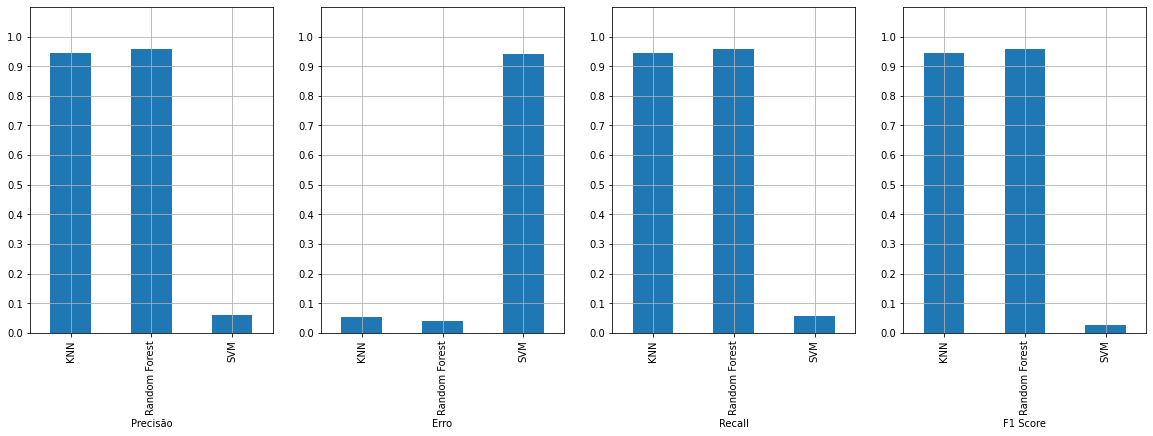

In [41]:
fig, axs = plt.subplots(1, len(resultado.columns), figsize=(20,6))
for idx, coluna in enumerate(resultado.columns):
    resultado[coluna].plot.bar(grid=True, ax=axs[idx])
    axs[idx].set_xlabel(coluna)
    axs[idx].set_ylim((0, 1.1))
    axs[idx].yaxis.set_ticks(np.arange(0, 1.1, 0.1))
plt.show()

In [42]:
df.shape

(141530, 25)

# Conclusões

De modo geral, o Random Forest parece a melhor solução para classificar o tráfego:

- Tem a melhor precisão
- Menor erro
- Menor tempo de predição

O SVM teve um desempenho baixíssimo, já que seu tempo de treino foi muito grande e precisou de limitação de iterações. O fato do dataset ser multiclasse pode ser um agravante no tempo de treino, além do tamanho do dataset. Então o SVM não é viável de forma alguma para esses dados.

Já o KNN teve um tempo de treino melhor que o Random Forest. No entanto, a penalidade acontece no tempo de predição, que é muito maior ao Random Forest.

Assim, o Random Forest é o melhor algoritmo de machine learning entre os três estudados.
